### Setup & Imports

In [1]:
!pip install git+https://github.com/huggingface/diffusers@a76f2ad538e73b34d5fe7be08c8eb8ab38c7e90c
!git clone https://github.com/huggingface/diffusers
!cd diffusers && git checkout a76f2ad538e73b34d5fe7be08c8eb8ab38c7e90c && cd ..

  Cloning https://github.com/huggingface/diffusers (to revision a76f2ad538e73b34d5fe7be08c8eb8ab38c7e90c) to c:\users\win_11\appdata\local\temp\pip-req-build-tkases18
  Resolved https://github.com/huggingface/diffusers to commit a76f2ad538e73b34d5fe7be08c8eb8ab38c7e90c
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers 'C:\Users\Win_11\AppData\Local\Temp\pip-req-build-tkases18'
  Running command git rev-parse -q --verify 'sha^a76f2ad538e73b34d5fe7be08c8eb8ab38c7e90c'
  Running command git fetch -q https://github.com/huggingface/diffusers a76f2ad538e73b34d5fe7be08c8eb8ab38c7e90c
  Running command git checkout -q a76f2ad538e73b34d5fe7be08c8eb8ab38c7e90c

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip
fatal: destination path 'diffusers' already exists and is not an empty directory.
HEAD is now at a76f2ad5 make style


In [2]:
import os
import warnings

import numpy as np
import torch
import wandb
from diffusers import StableDiffusionPipeline
from matplotlib import pyplot as plt
from PIL import Image
from scipy.spatial.distance import cdist
from transformers import AutoModel, AutoProcessor, CLIPModel, CLIPProcessor, ViTImageProcessor, ViTModel

In [3]:
warnings.filterwarnings('ignore')

### Config

In [4]:
# enable wandb logging
USE_WANDB = False

SEED = 42

INSTANCE_DIR = './data'
OUTPUT_DIR = './output'
SCRIPT_PATH = './diffusers/examples/dreambooth/train_dreambooth_lora.py'

INSTANCE_TOKEN = '[V]'
CLASS_TOKEN = 'robot'
INSTANCE_PROMPT = f'A {INSTANCE_TOKEN} {CLASS_TOKEN}'

STEPS = 1000
CHEKPOINT_STEPS = 100
LEARNING_RATE = 1e-4

PRETRAINED_MODEL = 'runwayml/stable-diffusion-v1-5'
LORA_RANK = 16
TRAIN_TEXT_ENCODER = False

WITH_PRIOR_PRESERVATION = False
CLASS_DIR = './class'
CLASS_PROMPT = 'a robot'

In [5]:
if USE_WANDB:
    config = {
        'pretrained_model': PRETRAINED_MODEL,
        'steps': STEPS,
        'lr': LEARNING_RATE,
        'lora_rank': LORA_RANK,
        'train_text_encoder': TRAIN_TEXT_ENCODER,
        'with_prior_preservation': WITH_PRIOR_PRESERVATION,
    }

    if WITH_PRIOR_PRESERVATION:
        config['class_prompt'] = CLASS_PROMPT

    run_name = ', '.join(
        [
            f'lr={LEARNING_RATE}',
            f'lora_rank={LORA_RANK}',
            f'text_encoder={TRAIN_TEXT_ENCODER}',
            f'preservation={WITH_PRIOR_PRESERVATION}',
        ],
    )

    wandb.login()
    wandb.init(
        project='dreambooth-lora-fine-tuning',
        config=config,
        name=run_name,
    )

### Training

In [6]:
params = [
    f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}"',
    f'--rank={LORA_RANK}',
    f'--seed={SEED}',
    f'--instance_data_dir="{INSTANCE_DIR}"',
    f'--output_dir="{OUTPUT_DIR}"',
    f'--instance_prompt="{INSTANCE_PROMPT}"',
    '--resolution=512',
    '--mixed_precision="fp16"',
    '--train_batch_size=1',
    '--gradient_accumulation_steps=1',
    f'--learning_rate={LEARNING_RATE}',
    '--lr_warmup_steps=0',
    f'--max_train_steps={STEPS}',
    f'--checkpointing_steps={CHEKPOINT_STEPS}',
]

if TRAIN_TEXT_ENCODER:
    params.append('--train_text_encoder')

if WITH_PRIOR_PRESERVATION:
    params.append('--with_prior_preservation')
    params.append(f'--class_prompt="{CLASS_PROMPT}"')
    params.append(f'--class_data_dir="{CLASS_DIR}"')

command = ' '.join([f'accelerate launch {SCRIPT_PATH}', *params])

In [7]:
!{command}

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
C:\Users\Win_11\PycharmProjects\dreambooth-lora-fine-tuning\venv\lib\site-packages\accelerate\accelerator.py:377: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
09/04/2023 20:39:34 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models 

### Image utils

In [8]:
def plot_prompt(outputs: dict[int, dict[str, list[Image]]], prompt: str) -> None:
    fig = plt.figure(figsize=(10, 2 * len(outputs)))
    fig.suptitle(f'Prompt: "{prompt}"', y=1.05)

    subfigs = fig.subfigures(len(outputs), ncols=1)
    for step_idx, step in enumerate(outputs):
        subfigs[step_idx].suptitle(f'Step: {step}')
        images = outputs[step][prompt]
        axis = subfigs[step_idx].subplots(nrows=1, ncols=4)
        for image_idx, image in enumerate(images):
            axis[image_idx].imshow(image)
            axis[image_idx].axis('off')

def load_images(image_dir: str) -> list[Image]:
    images = []
    for image_filename in os.listdir(image_dir):
        images.append(Image.open(os.path.join(image_dir, image_filename)))
    return images

### Validation util

In [9]:
def generate_images(
    pretrained_model: str,
    checkpoint_path: str,
    prompts: list[str],
    load_text_encoder: bool,
    n_images_per_prompt: int = 4,
) -> dict[str, list[Image]]:
    generator = torch.Generator(device='cuda').manual_seed(SEED)
    
    model = StableDiffusionPipeline.from_pretrained(
        pretrained_model, torch_dtype=torch.half, safety_checker=None,
    )
    if load_text_encoder:
        model.load_lora_weights(checkpoint_path)
    else:
        model.unet.load_attn_procs(checkpoint_path)
    model = model.to('cuda')

    outputs = {}
    for prompt in prompts:
        prompt_images = model(
            prompt=prompt,
            num_images_per_prompt=n_images_per_prompt,
            generator=generator,
        ).images
        outputs[prompt] = prompt_images
    return outputs

### Metric implemetations

In [10]:
@torch.no_grad()
def get_vit_embeddings(
    model: ViTModel, processor: ViTImageProcessor, images: list[Image],
) -> np.ndarray:
    pixel_values = processor(
        images=images, return_tensors='pt',
    ).pixel_values.to(model.device)
    return model(
        pixel_values=pixel_values,
    ).last_hidden_state.cpu().numpy().mean(1)


@torch.no_grad()
def get_clip_image_embeddings(
    model: CLIPModel, processor: CLIPProcessor, images: list[Image],
) -> np.ndarray:
    pixel_values = processor(
        images=images, return_tensors='pt',
    ).pixel_values.to(model.device)
    return model.get_image_features(
        pixel_values=pixel_values,
    ).cpu().numpy()


@torch.no_grad()
def get_clip_text_embeddings(
    model: CLIPModel, processor: CLIPProcessor, texts: list[str],
) -> np.ndarray:
    tokens = processor(
        text=texts, return_tensors='pt', padding=True,
    )
    return model.get_text_features(
        input_ids=tokens.input_ids.to(model.device),
        attention_mask=tokens.attention_mask.to(model.device),
    ).cpu().numpy()

In [11]:
# DINO
def calculate_dino_metric(
    outputs: dict[int, dict[str, list[Image]]],
    instance_dir: str,
) -> dict[int, float]:
    processor = AutoProcessor.from_pretrained('facebook/dino-vits16')
    model = AutoModel.from_pretrained('facebook/dino-vits16').eval().to('cuda')

    instance_images = load_images(instance_dir)
    instance_embeddings = get_vit_embeddings(model, processor, instance_images)

    dino_metric_values = {}
    for checkpoint_step, checkpoint_output in outputs.items():
        checkpoint_embeddings = []
        for prompt_images in checkpoint_output.values():
            checkpoint_embeddings.append(
                get_vit_embeddings(model, processor, prompt_images),
            )
        
        similarities = 1 - cdist(
            instance_embeddings,
            np.concatenate(checkpoint_embeddings),
            metric='cosine',
        )
        dino_metric_values[checkpoint_step] = similarities.mean()

    return dino_metric_values

In [12]:
# CLIP-I
def calculate_clip_i_metric(
    outputs: dict[int, dict[str, list[Image]]],
    instance_dir: str,
) -> dict[int, float]:
    processor = AutoProcessor.from_pretrained('openai/clip-vit-base-patch32')
    model = AutoModel.from_pretrained('openai/clip-vit-base-patch32').eval().to('cuda')

    instance_images = load_images(instance_dir)
    instance_embeddings = get_clip_image_embeddings(model, processor, instance_images)

    clip_i_metric_values = {}
    for checkpoint_step, checkpoint_output in outputs.items():
        checkpoint_embeddings = []
        for prompt_images in checkpoint_output.values():
            checkpoint_embeddings.append(
                get_clip_image_embeddings(model, processor, prompt_images),
            )
        
        similarities = 1 - cdist(
            instance_embeddings,
            np.concatenate(checkpoint_embeddings),
            metric='cosine',
        )
        clip_i_metric_values[checkpoint_step] = similarities.mean()

    return clip_i_metric_values

In [13]:
# CLIP-T
def calculate_clip_t_metric(
    outputs: dict[int, dict[str, list[Image]]],
    validation_prompts: list[str],
    instance_token: str,
) -> dict[int, float]:
    processor = AutoProcessor.from_pretrained('openai/clip-vit-base-patch32')
    model = AutoModel.from_pretrained('openai/clip-vit-base-patch32').eval().to('cuda')

    updated_validation_prompts = []
    for validation_prompt in validation_prompts:
        validation_prompt = validation_prompt.replace(f' {instance_token} ', ' ')
        updated_validation_prompts.append(validation_prompt)

    prompt_embeddings = get_clip_text_embeddings(model, processor, updated_validation_prompts)
    
    clip_t_metric_values = {}
    for checkpoint_step, checkpoint_output in outputs.items():
        checkpoint_similarities = 0
        for prompt_idx, prompt_images in enumerate(checkpoint_output.values()):
            image_embeddings = get_clip_image_embeddings(model, processor, prompt_images)
        
            similarities = 1 - cdist(
                np.expand_dims(prompt_embeddings[prompt_idx], 0),
                image_embeddings,
                metric='cosine',
            )
            checkpoint_similarities += similarities.mean()
        clip_t_metric_values[checkpoint_step] = checkpoint_similarities / len(checkpoint_output)

    return clip_t_metric_values

### Validation

In [14]:
VALIDATION_PROMPTS = [
    f'a {INSTANCE_TOKEN} {CLASS_TOKEN} in the snow',
    f'a {INSTANCE_TOKEN} {CLASS_TOKEN} on a cobblestone street',
    f'a {INSTANCE_TOKEN} {CLASS_TOKEN} with a mountain in the background',
    f'a {INSTANCE_TOKEN} {CLASS_TOKEN} wearing a santa hat',
    f'a red {INSTANCE_TOKEN} {CLASS_TOKEN}',
]

In [15]:
checkpoint_step = CHEKPOINT_STEPS
outputs = {}
while checkpoint_step <= STEPS:
    checkpoint_dir = f'checkpoint-{checkpoint_step}'
    checkpoint_path = os.path.join(
        OUTPUT_DIR,
        checkpoint_dir,
        'pytorch_lora_weights.safetensors',
    )
    
    checkpoint_output = generate_images(
        pretrained_model=PRETRAINED_MODEL,
        checkpoint_path=checkpoint_path,
        prompts=VALIDATION_PROMPTS,
        load_text_encoder=TRAIN_TEXT_ENCODER,
    )

    outputs[checkpoint_step] = checkpoint_output

    checkpoint_step += CHEKPOINT_STEPS

unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [16]:
dino_metric_values = calculate_dino_metric(outputs, INSTANCE_DIR)
clip_i_metric_values = calculate_clip_i_metric(outputs, INSTANCE_DIR)
clip_t_metric_values = calculate_clip_t_metric(outputs, VALIDATION_PROMPTS, INSTANCE_TOKEN)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
if USE_WANDB:
    wandb.define_metric('DINO', summary='max')
    wandb.define_metric('CLIP-I', summary='max')
    wandb.define_metric('CLIP-T', summary='max')
    
    for checkpoint_step, checkpoint_output in outputs.items():
        wandb.log({'DINO': dino_metric_values[checkpoint_step]}, step=checkpoint_step)
        wandb.log({'CLIP-I': clip_i_metric_values[checkpoint_step]}, step=checkpoint_step)
        wandb.log({'CLIP-T': clip_t_metric_values[checkpoint_step]}, step=checkpoint_step)
        
        for prompt, prompt_images in checkpoint_output.items():
            wandb.log(
                {prompt: [wandb.Image(image) for image in prompt_images]},
                step=checkpoint_step,
            )

### Visualization

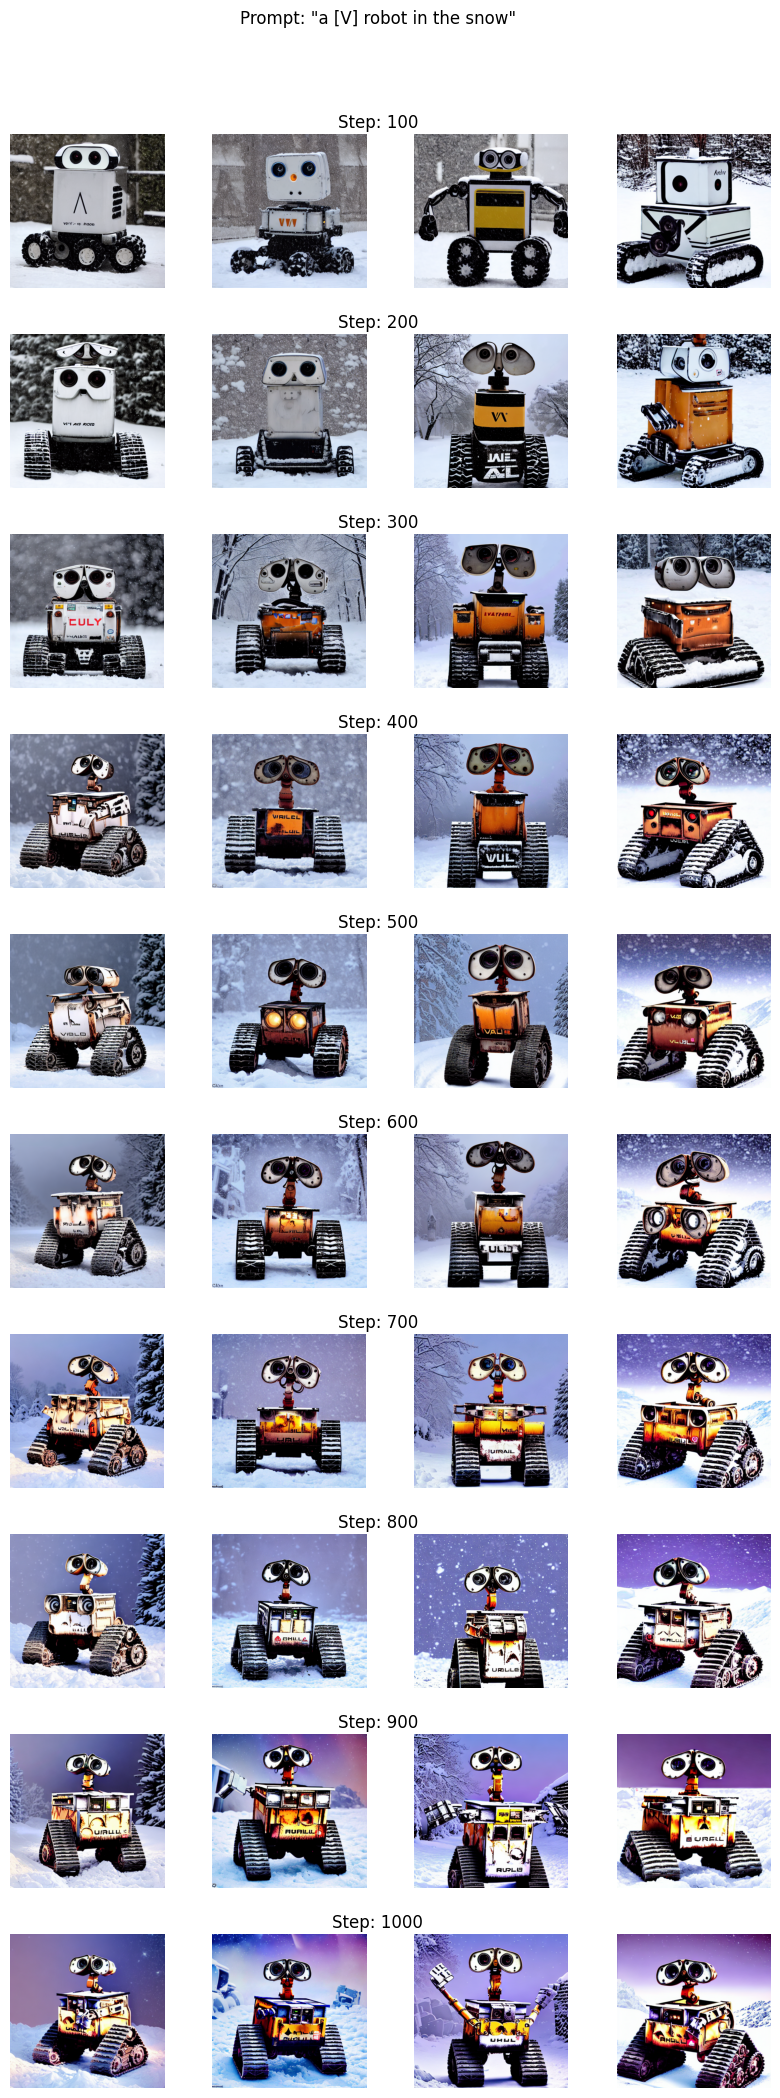

In [18]:
# Here you can change the index to plot a different prompt
plot_prompt(outputs, VALIDATION_PROMPTS[0])

In [19]:
wandb.finish()